# Full Data

In [3]:
import importlib
#importlib.reload(sm)

In [145]:
import pandas as pd
import numpy as np
import statistics
from embo import InformationBottleneck
import HMM_beads_utils as ut
import smfile as sm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import scipy.stats
import seaborn as sns
import os,ndd,pickle
from adjustText import adjust_text
import adjustText
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
import plotnine
import math
cmap = plt.get_cmap("tab10")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
colortemplate = pd.read_csv("../UrnConfidenceQuestionnaire/Data/vickiecolorlist.csv")

In [6]:
data_location = "../../../UrnTaskV/data/"
stimuli_location = "../../../UrnTaskV/stimuli/low_hazard_HMM10/"

file = os.listdir(data_location)[0]
print(file) 

df = pd.read_csv(data_location + file)
print(df)

UrnTaskV_PARTICIPANT_SESSION_2021-10-04_01h06.05.925.csv
                  trial_type  trial_index  time_elapsed internal_node_id  \
0                   pavlovia            0           567          0.0-0.0   
1                    preload            1          3561          0.0-1.0   
2              external-html            2         11604      0.0-2.0-0.0   
3        survey-multi-choice            3         16011      0.0-2.0-1.0   
4                survey-text            4         19052      0.0-2.0-2.0   
...                      ...          ...           ...              ...   
3058   image-button-response         3058       1478633   0.0-18.0-2.498   
3059   image-button-response         3059       1479039   0.0-18.0-0.499   
3060   image-button-response         3060       1479346   0.0-18.0-1.499   
3061   image-button-response         3061       1479849   0.0-18.0-2.499   
3062  html-keyboard-response         3062       1482288         0.0-19.0   

     Script_Picker     Block_T

In [9]:
os.listdir(data_location)

fl = os.listdir(data_location)[-1]

['UrnTaskV_PARTICIPANT_SESSION_2021-10-04_01h06.05.925.csv',
 'UrnTaskV_5929e024943e670001cde06b_SESSION_2021-10-05_19h22.02.320.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-10-02_23h59.08.92.csv',
 'UrnTaskV_60c13bce0d8616e48d044bd0_SESSION_2021-10-05_19h17.15.677.csv',
 'UrnTaskV_603e5aad160c3ee04e07e8d3_SESSION_2021-10-05_19h02.35.540.csv',
 'UrnTaskV_6125082992be0cc689b6f8ba_SESSION_2021-10-06_17h03.44.652.csv',
 'UrnTaskV_5f23059ab07e8c06aeb696e2_SESSION_2021-10-05_20h14.33.349.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-08-20_13h04.55.703.csv',
 'UrnTaskV_5f61578829b2480f4a57565a_SESSION_2021-10-06_16h09.53.688.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-10-04_09h51.41.2.csv',
 'UrnTaskV_5f627edffdaccd2edb7df1fb_SESSION_2021-10-05_11h30.47.341.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-04-21_15h07.21.815.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-10-02_23h03.30.37.csv',
 'UrnTaskV_60d70c9a87b278547b2988ef_SESSION_2021-10-05_19h10.16.371.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-05-04_23h4

In [10]:
df = pd.read_csv(data_location + fl)

In [11]:
df['Script_Picker'].unique()
df.shape

array(['Actual'], dtype=object)

(3063, 18)

In [12]:
def preprocess_sub_data(data_location, stimuli_location, training_length = 10, condition_string = "2021-09"):
    full_data = pd.DataFrame()
    meta_data = pd.DataFrame()
    subject_list = []
    prev_stim = []
    for ix, file in enumerate(os.listdir(data_location)):
        if file[0] == ".": continue
        if condition_string not in file: continue
        df = pd.read_csv(data_location + file)
        #print(ix + 1, df.shape, file)
        if df.shape[0] < 3000: continue
        print(file)
        sub_data, meta = preprocess_sub_data_helper(data_location + file, stimuli_location, prev_stim, training_length)
        if sub_data['FullSubject'][0] not in subject_list:
            #print('here')
            subject_list.append(sub_data['FullSubject'][0])
            prev_stim = sub_data[['Jar','Bead']]
            full_data = full_data.append(sub_data[10:],ignore_index=True)
            meta_data = meta_data.append(meta,ignore_index=True)
        #print(subject_list)
    return full_data, meta_data
        
def preprocess_sub_data_helper(file_location, stimuli_location, prev_stim, training_length = 10, trial_length = 500, numprevious = 10):
    ## Read in subject data
    df = pd.read_csv(file_location)
    
    ## Read in subject stimulus data
    seqID = df['Script_Picker'].unique()
    #print(seqID)
    if seqID[0] == "Actual":
        pseq = pd.read_csv(stimuli_location + 'low_hazard_HMM_Actual.csv')
    else:
        pseq_lowtrial = pd.read_csv(stimuli_location + 'low_hazard_HMM'+str(seqID[1])+'.csv')
        pseq_low1 = pd.read_csv(stimuli_location + 'low_hazard_HMM'+str(seqID[2])+'.csv')
        pseq_low2 = pd.read_csv(stimuli_location + 'low_hazard_HMM'+str(seqID[3])+'.csv')
        pseq = pd.concat([pseq_lowtrial[:training_length],pseq_low1[:trial_length], pseq_low2[:trial_length]])
      
    ## Subject identifier
    sub = sm.find_between(df['responses'][5],":\"","\"}")
    print(sub)
    
    ## Get bead and confidence responses
    temp = df.dropna(subset=['stimulus'])
    resp_combined = temp.loc[temp['stimulus'].str.contains("NewTrial|NoChoice")].reset_index()
    bead_resp = [0 if blah > 1 else 1 for blah in resp_combined['response']]
    confid_resp = [1 if blah % 2 == 0 else 0 for blah in resp_combined['response']]
    
    ## Get true sequence of beads and jars
    pseq = pseq[:len(bead_resp)].reset_index()
    
    ## Gather outputs
    D = pd.DataFrame({
        'FullSubject': sub,
        'Subject': sub[:6],
        'Trial': [i for i in np.arange(len(pseq))],
        'Jar': [int(2-i) for i in pseq['Urn']],
        'Bead': [int(2-i) for i in pseq['Bead']],
        'Response': bead_resp,
        'Confidence': confid_resp#,
        #'Combined_response': resp_combined['response']
    })
    D['Correct'] = [1 if D['Response'][i] == D['Bead'][i] else 0 for i in np.arange(len(D))]
    D['History'] = sm.get_previous_n_beads(numprevious, D['Bead'])

    ## Check stuff
    check_set = ['Images/BlackBeadChoiceWrong.png',
                'Images/WhiteBeadChoiceWrong.png',
                'Images/BlackBeadChoiceCorrect.png',
                'Images/WhiteBeadChoiceCorrect.png']
    check_set_string = "|".join(check_set)
    
    bead_check_set = ['Images/NoChoice.png',
                      'Images/NewTrialWC.png',
                      'Images/NewTrialBC.png']
    bead_check_set_string = "|".join(bead_check_set)

    image = temp['stimulus'].loc[temp['stimulus'].str.contains(bead_check_set_string)].reset_index(drop = True)
    check_table = pd.DataFrame()
    check_table['stim'] = temp['stimulus'].loc[temp['stimulus'].str.contains(check_set_string)]
    check_table['check_resp'] = [0 if "White" in i else 1 for i in check_table['stim']]
    check_table['check_correct'] = [0 if "Wrong" in i else 1 for i in check_table['stim']]
    check_table['check_bead'] = [0 if "WC" in i else 1 for i in image]#.reset_index(drop = True)
    check_table = check_table.reset_index()

    
    check1 = list(D['Correct']) != list(check_table['check_correct'])
    check2 = list(D['Response']) != list(check_table['check_resp'])
    check3 = list(D['Bead'][0:999]) != list(check_table['check_bead'][1:1000])
    #check4 = list(D['Bead'][9:499]) != list(check_table['check_bead'][510:1000])
    #print(check4, "here")
    #print(check_table[0:20])
    #print(list(D['Bead'][10:20]))
    #print(list(check_table['check_bead'][510:520]))
    
    #print(sub)
    #print(D[30:40])
    #print(check_table[30:40])
    #print(check3)
    #print(check_table[10:40], check_table[510:540])
    #print(repr(' '.join(str(e) for e in 2.0-np.array(check_table['check_bead'][11:50]))))
    
    if check1 | check2 | check3:
        print("PROBLEM", sub, np.where([D['Correct'][i] != check_table['check_correct'][i] for i in np.arange(len(D))]))
        #print(file_location)
        #print(D['Correct'],check_table['check_correct'])
    #print(check_table[0:40])
    
    if len(prev_stim) != 0:
        if not prev_stim.equals(D[['Jar', "Bead"]]):
            print("PROBLEM 2")
        
    M = pd.DataFrame({
    'FullSubject': sub,
    'Subject': [sub[:6]],
    'FullSubject': sub,
    'Gender': sm.find_between(df['responses'][3],":\"","\","),
    'Age': sm.find_between(df['responses'][4],":\"","\"}"),
    'Ethnicity': sm.find_between(df['responses'][3],"1\":\"","\"}")
    })
    M
    return D, M

In [438]:
def preprocess_sub_data(data_location, stimuli_location, training_length = 10, condition_string = ""):
    full_data = pd.DataFrame()
    meta_data = pd.DataFrame()
    subject_list = []
    prev_stim = []
    for ix, file in enumerate(os.listdir(data_location)):
        if file[0] == ".": continue
        if condition_string not in file: continue
        df = pd.read_csv(data_location + file)
        #print(ix + 1, df.shape, file)
        if df.shape[0] < 3000: 
            try:
                sub = sm.find_between(df['responses'][5],":\"","\"}")
                print("short", sub, df.shape)
                continue
            except:
                print("too short", df.shape)
                continue
        if ("2021-04" in file) or ("2021-05" in file) or ("2021-06" in file) or ("2021-07" in file) or ("2021-08-0" in file): continue
        if ("2021-08-17_22h04" in file) or ("2021-08-09_17h55" in file): continue
        #print(file)
        sub_data, meta = preprocess_sub_data_helper(data_location + file, stimuli_location, prev_stim, training_length)
        #if sub_data['FullSubject'][0] == "": print(file)
        if sub_data['FullSubject'][0] not in subject_list:
            #print('here')
            subject_list.append(sub_data['FullSubject'][0])
            prev_stim = sub_data[['Jar','Bead']]
            full_data = full_data.append(sub_data[10:],ignore_index=True)
            meta_data = meta_data.append(meta,ignore_index=True)
        #print(subject_list)
    return full_data, meta_data, subject_list
        
def preprocess_sub_data_helper(file_location, stimuli_location, prev_stim, training_length = 10, trial_length = 500, numprevious = 10):
    ## Read in subject data
    df = pd.read_csv(file_location)
    
    ## Read in subject stimulus data
    seqID = df['Script_Picker'].unique()
    #print(seqID)
    if seqID[0] == "Actual":
        pseq = pd.read_csv(stimuli_location + 'low_hazard_HMM_Actual.csv')
    else:
        pseq_lowtrial = pd.read_csv(stimuli_location + 'low_hazard_HMM'+str(seqID[1])+'.csv')
        pseq_low1 = pd.read_csv(stimuli_location + 'low_hazard_HMM'+str(seqID[2])+'.csv')
        pseq_low2 = pd.read_csv(stimuli_location + 'low_hazard_HMM'+str(seqID[3])+'.csv')
        pseq = pd.concat([pseq_lowtrial[:training_length],pseq_low1[:trial_length], pseq_low2[:trial_length]])
      
    ## Subject identifier
    sub = sm.find_between(df['responses'][5],":\"","\"}")
    if sub == '25': sub = '6143164ea86960b2a5a12f45'
    if sub == '': 
        sub = sm.find_between(file_location, "UrnTaskV_", "_SESSION")
        print("blank sub: ", sub)
    #print(sub)
    
    ## Get bead and confidence responses
    temp = df.dropna(subset=['stimulus'])
    resp_combined = temp.loc[temp['stimulus'].str.contains("NewTrial|NoChoice")].reset_index()
    bead_resp = [0 if blah > 1 else 1 for blah in resp_combined['response']]
    confid_resp = [1 if blah % 2 == 0 else 0 for blah in resp_combined['response']]
    
    ## Get true sequence of beads and jars
    pseq = pseq[:len(bead_resp)].reset_index()
    
    ## Gather outputs
    D = pd.DataFrame({
        'FullSubject': sub,
        'Subject': sub[:8],
        'Trial': [i for i in np.arange(len(pseq))],
        'Jar': [int(2-i) for i in pseq['Urn']],
        'Bead': [int(2-i) for i in pseq['Bead']],
        'Response': bead_resp,
        'Confidence': confid_resp#,
        #'Combined_response': resp_combined['response']
    })
    D['Correct'] = [1 if D['Response'][i] == D['Bead'][i] else 0 for i in np.arange(len(D))]
    D['History'] = sm.get_previous_n_beads(numprevious, D['Bead'])

    ## Check stuff
    check_set = ['Images/BlackBeadChoiceWrong.png',
                'Images/WhiteBeadChoiceWrong.png',
                'Images/BlackBeadChoiceCorrect.png',
                'Images/WhiteBeadChoiceCorrect.png']
    check_set_string = "|".join(check_set)
    
    bead_check_set = ['Images/NoChoice.png',
                      'Images/NewTrialWC.png',
                      'Images/NewTrialBC.png']
    bead_check_set_string = "|".join(bead_check_set)

    image = temp['stimulus'].loc[temp['stimulus'].str.contains(bead_check_set_string)].reset_index(drop = True)
    check_table = pd.DataFrame()
    check_table['stim'] = temp['stimulus'].loc[temp['stimulus'].str.contains(check_set_string)]
    check_table['check_resp'] = [0 if "White" in i else 1 for i in check_table['stim']]
    check_table['check_correct'] = [0 if "Wrong" in i else 1 for i in check_table['stim']]
    #check_table['check_bead'] = [0 if "WC" in i else 1 for i in image]#.reset_index(drop = True)
    check_table['check_bead'] = [0 if (("White" in i) and ("Correct" in i)) or 
                                  (("Black" in i) and ("Wrong" in i))
                                  else 1 for i in check_table['stim']]#.reset_index(drop = True)
    check_table = check_table.reset_index()
    #print(check_table)

        
    #D['Jar'][510:1010] = D['Jar'][10:510].copy()
    #D['Bead'] = check_table['check_bead']
    #D['FullSubject'][510:1010] = ['2_' + sub]*500
    #D['Subject'][510:1010] = [sub[:6] + "_2"]*500
    #D['Trial'][510:1010] = D['Trial'][10:510].copy()

    D['Correct'] = [1 if D['Response'][i] == D['Bead'][i] else 0 for i in np.arange(len(D))]
    D['History'] = sm.get_previous_n_beads(numprevious, D['Bead'])
    
    check1 = list(D['Correct']) != list(check_table['check_correct'])
    check2 = list(D['Response']) != list(check_table['check_resp'])
    check3 = list(D['Bead']) != list(check_table['check_bead'])
    check4 = list(check_table['check_bead'][10:500]) != list(check_table['check_bead'][510:1000])
    #print(check4, "here")
    
    if check1 | check2 | check3:
        print("PROBLEM", sub, np.where([D['Correct'][i] != check_table['check_correct'][i] for i in np.arange(len(D))]))
        #print(file_location)
        #print(D['Correct'],check_table['check_correct'])
    #print(check_table[0:40])
    
    if len(prev_stim) != 0:
        if not prev_stim.equals(D[['Jar', "Bead"]]):
            print("PROBLEM 2")
    
    M = pd.DataFrame({
        'FullSubject': sub,
        'Subject': [sub[:8]],
        'FullSubject': sub,
        'Gender': sm.find_between(df['responses'][3],":\"","\","),
        'Age': sm.find_between(df['responses'][4],":\"","\"}"),
        'Ethnicity': sm.find_between(df['responses'][3],"1\":\"","\"}")
    })
    
    return D, M

In [439]:
D, metaD, slist = preprocess_sub_data(data_location, stimuli_location)
Ddict = {'orig': D}

#D

short 611b1f8d65d3749d42e746c2 (20, 17)
short 61498c47141e1638b1d6a1b0 (6, 15)
short 5e46f51bc3298c1bf813a984 (58, 18)
too short (3, 13)
short 610c4ee070fd5e59a42868d5 (56, 18)
too short (1, 6)
too short (1, 6)
too short (2, 11)
too short (2, 11)
short 5c5d36bc034e280001644c3b (20, 17)
short 613bb9261eaf6494bbf5e43f (22, 17)
short 612bf5acefbf7a678c8b6ba5 (6, 15)
short 123 (124, 18)
too short (2, 11)
too short (2, 11)
short 611eb4cfb28943e584e11af0 (64, 18)
short 5ecf7cc3f50eea1fbefda0fa (24, 17)
short 123 (125, 18)
short 123 (20, 17)
too short (2, 11)
short 5cce4f4c0305ed000158a5d9 (15, 17)
short 6151a9fde0ce9ae0e0f2fee3 (17, 17)
too short (2, 11)
short 610e72ad6f61aec012cc350a (6, 15)
short 5c73477642a5070001a2f940 (1049, 18)
too short (2, 11)
too short (1, 6)
too short (2, 11)
too short (1, 6)
too short (2, 11)
blank sub:  60ffa96e53f71dd3d469cb7b
too short (2, 11)
short 123 (50, 18)
short 60fd65993898cd4ef35a4f0c (43, 18)
short 615185cd52a54f73866b69bf (6, 15)
too short (2, 11)
sho

In [380]:
taskpeople = set(D.FullSubject)
len(taskpeople)

411

In [445]:
len(set([s[:6] for s in slist]))

408

In [381]:
surveydata = pd.read_csv("../../Urn-Confidence/UrnConfidenceQuestionnaire/Data/Urn Task Final - Ind_October 8, 2021_06.02.csv")

In [382]:
surveypeople = set(surveydata['Prolific ID'])
len(surveypeople)
#surveypeople

429

In [483]:
taskpeople.difference(surveypeople)
surveypeople.difference(taskpeople)
len(surveypeople.difference(taskpeople))

len(surveypeople.intersection(taskpeople))

{'613a45db483e8692ed719d44'}

{' 6108faaf61902f1f5ab964ee',
 '5d8934d9a3dd000001ce8676',
 '5ec967f3d0688048464a6f79',
 '5f482ac357a1ab2e05c3f0d6',
 '5f783a466246ee3bac5c4a03',
 '5fadba1cd0ebd31b976fd1dc',
 '60fee797279b8772ab431aac',
 '610998862cd55208600bbf79',
 '610d4625a80a8417bb7f911d',
 '611142b90d34d6815fe5fd9f',
 '6119529080ac976c7006d583',
 '61430f7d7bea7798cd8e62c0',
 '614d7d97c94105e2f6a56217',
 '615161177bcb4fc3d517dc44',
 '6155af79ea994abf58fe0792',
 'Ana Nava',
 'Enter your Prolific ID',
 'asdf',
 '{"ImportId":"QID20_TEXT"}'}

19

410

In [485]:
'5d02695334bace00012a468c' in surveypeople.intersection(taskpeople)

True

In [489]:
sd = surveydata.filter(regex='_|ID')
sd[sd.isna().any(axis=1)]
notcomplete = sd[sd.isna().any(axis=1)]['Prolific ID']

,Prolific ID,DASS21_1,DASS21_2,DASS21_3,DASS21_4,DASS21_5,DASS21_6,DASS21_7,DASS21_8,DASS21_9,...,EAT26_18,EAT26_19,EAT26_20,EAT26_21,EAT26_22,EAT26_23,EAT26_24,EAT26_25,EAT26_26,EAT26_27
8,asdf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,5d02695334bace00012a468c,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [490]:
surveydata[(surveydata['SSMS43_38'] != '2') | (surveydata['EAT26_18'] != '6')][['Prolific ID', 'SSMS43_38', 'EAT26_18']]

,Prolific ID,SSMS43_38,EAT26_18
0,Enter your Prolific ID,"For each statement, please indicate whether or...",Please fill out the questions below as accurat...
1,"{""ImportId"":""QID20_TEXT""}","{""ImportId"":""QID4_38""}","{""ImportId"":""QID17_18""}"
2,asdf,1,3
8,asdf,NaN,NaN
44,5d02695334bace00012a468c,2,NaN
45,5a63b47063394a0001555a41,2,1
55,60e568d9f1dadc0430936bd9,2,5
57,60e052e35d0658f5716b1d19,1,6
74,5fd7f1124c7aaa0f6c34de58,2,4
179,5c4742f0b521ee00019ab913,2,1


In [491]:
failsub = surveydata[(surveydata['SSMS43_38'] != '2') | (surveydata['EAT26_18'] != '6')][['Prolific ID', 'SSMS43_38', 'EAT26_18']]['Prolific ID']
failsub = failsub.append(notcomplete).unique()
failsub
len(failsub)

notask = taskpeople.difference(surveypeople)
failsub = set(failsub).union(notask)
failsub
len(failsub)


array(['Enter your Prolific ID', '{"ImportId":"QID20_TEXT"}', 'asdf',
       '5d02695334bace00012a468c', '5a63b47063394a0001555a41',
       '60e568d9f1dadc0430936bd9', '60e052e35d0658f5716b1d19',
       '5fd7f1124c7aaa0f6c34de58', '5c4742f0b521ee00019ab913',
       '6142382025f4c095cfe7810e', '61425d5409cfd1a472b532b0',
       '6123ae8b7ff937485c65275b', '61479f2f9feb665527409a73',
       '5ea720a669cae10d910fba3e', '61546401a50b39a6148ea24f',
       '5f2e21fcfc40b2185098930c', '5df50a49a98a7a3924e4137e',
       '5fd2416e5061f30735e202e9', '61150dddbf0b47b7de71f4c4',
       '60cfac014e090c96b56c65f8', '5fe3f76d520dd11597760c63',
       '60586de285771e597c5458cc', '5f627edffdaccd2edb7df1fb',
       '6138b548cc872cc7edbfac1e', '613a8d9064fa145e4b932130',
       '610998862cd55208600bbf79', '5de2cac379af44000dd574b1'],
      dtype=object)

27

{'5a63b47063394a0001555a41',
 '5c4742f0b521ee00019ab913',
 '5d02695334bace00012a468c',
 '5de2cac379af44000dd574b1',
 '5df50a49a98a7a3924e4137e',
 '5ea720a669cae10d910fba3e',
 '5f2e21fcfc40b2185098930c',
 '5f627edffdaccd2edb7df1fb',
 '5fd2416e5061f30735e202e9',
 '5fd7f1124c7aaa0f6c34de58',
 '5fe3f76d520dd11597760c63',
 '60586de285771e597c5458cc',
 '60cfac014e090c96b56c65f8',
 '60e052e35d0658f5716b1d19',
 '60e568d9f1dadc0430936bd9',
 '610998862cd55208600bbf79',
 '61150dddbf0b47b7de71f4c4',
 '6123ae8b7ff937485c65275b',
 '6138b548cc872cc7edbfac1e',
 '613a45db483e8692ed719d44',
 '613a8d9064fa145e4b932130',
 '6142382025f4c095cfe7810e',
 '61425d5409cfd1a472b532b0',
 '61479f2f9feb665527409a73',
 '61546401a50b39a6148ea24f',
 'Enter your Prolific ID',
 'asdf',
 '{"ImportId":"QID20_TEXT"}'}

28

In [492]:
D = D[~D['FullSubject'].isin(failsub)].reset_index(drop = True)
metaD = metaD[~metaD['FullSubject'].isin(failsub)].reset_index(drop = True)

In [493]:
len(set(D.FullSubject))

387

In [389]:
D
metaD

,FullSubject,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
0,60b610d8c3c4f177c8337729,60b610d8,10,0,0,0,0,1,00001001001
1,60b610d8c3c4f177c8337729,60b610d8,11,0,0,0,1,1,00010010010
2,60b610d8c3c4f177c8337729,60b610d8,12,0,0,0,1,1,00100100100
3,60b610d8c3c4f177c8337729,60b610d8,13,0,0,0,1,1,01001001000
4,60b610d8c3c4f177c8337729,60b610d8,14,0,0,0,1,1,00010010000
...,...,...,...,...,...,...,...,...,...
386995,610d8166e8a8d5557df42c11,610d8166,1005,0,0,0,1,1,00010100000
386996,610d8166e8a8d5557df42c11,610d8166,1006,0,1,0,1,0,00101000000
386997,610d8166e8a8d5557df42c11,610d8166,1007,0,0,1,0,0,01010000001
386998,610d8166e8a8d5557df42c11,610d8166,1008,0,1,0,1,0,00100000010


,FullSubject,Subject,Gender,Age,Ethnicity
0,60b610d8c3c4f177c8337729,60b610d8,Male,36,White
1,5929e024943e670001cde06b,5929e024,Female,28,White
2,613cb9a1ccf4ca3a5150522e,613cb9a1,Male,23,White
3,60c13bce0d8616e48d044bd0,60c13bce,Male,26,White
4,603e5aad160c3ee04e07e8d3,603e5aad,Male,26,White
...,...,...,...,...,...
382,5ed2994518f6bd211a146df2,5ed29945,Male,50,White
383,60d20236448971833317b4a9,60d20236,Male,20,White
384,611154fe069a615f244b49aa,611154fe,Female,24,White
385,5ee00b0d5f5ead34f63f2c47,5ee00b0d,Male,26,White


In [390]:
D[D.FullSubject == ""]

,FullSubject,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History


In [391]:
len(D.FullSubject.unique())
len(surveypeople)

387

429

In [392]:
398-356
429-387

42

42

In [393]:
tst = '5e46f51bc3298c1bf813a984'
tst in surveypeople
tst in D.FullSubject.unique()
tst in taskpeople
'' in D.FullSubject.unique()

False

False

False

False

In [329]:
approvesubs = ','.join([sub for sub in D.FullSubject.unique()])
approvesubs
#surveypeople

'60b610d8c3c4f177c8337729,613cb9a1ccf4ca3a5150522e,6153b5513ccada2d35fae508,5a84b912000dab00018c98a9,60b8b246724192f75f1bde20,6032a88a2b8e882a37cc2766,5d8272296cca0b001759f562,613a886056265d62028d15d2,610d57d6edc4728a09f5039b,5f0a9094da2883360c73fd9f,5f4f9deca0830d07329e0efa,614b412188d2d87eab0e82a6,5fa45dc96da3af0b7dcba9a8,5efb8358f81cbe0f08950fe4,6126605a4bafe56d99d6371d,609555cfb1d8b347cdbbf6b4,60b5bb67d1254a703cb01a5a,613aeee1621e5eccccc8cea2,6151e2800e631a9321e7c4ee,6154918f83e8ca861b23ea04,56c641da305eaa000bf21231,6140ef8d27499e70e8740918,56e55e5cb2093a000c4f107c,6150842d1d21ce2cf9f024e5,60379ddc5275b901eaa1ca3c,614f297777d0d8f5e2a5b354,60dbbc0ae0cea5626de2ac0a,5ac01e17e1546900019bd462,61098f2ce1a717deb35291f1,5dad865e32175a0014451b20,6149c45d3b339b0df37ffefc,5dea5762b3adb2175d6ccae0,6141e484da042e7f07a3ef7a,60fbc53a81120344612e0d08,5faa6cab8ac7a937a5240fcb,5b52f4933234ab00014ca442,61544c7e85951454f9c5b60e,57fe6296035f6e0001d71d05,5f418da10dab34340bd50d60,59b39cd4c05bb50001eb3b81

In [403]:
subsurdat = pd.read_csv("../../Urn-Confidence/UrnConfidenceQuestionnaire/Data/Prolific/prolific_export_615b9fd27c9c8768cf210a6f.csv")

#subs = subsurdat.participant_id
#subs

subs = subsurdat[subsurdat.participant_id.isin(D.FullSubject)].participant_id

approvesubs = ','.join(subs)
approvesubs

'5e617adcc4e9d604ee3fdb8b,613ae7ee4792e432307450d4,603567ff63b2a4e1755011d8,5fc67d0d734f6e02dc70bb86,613a66ff028c12b24aa7c559,613fde254759385b5d464ee5,613bac1c79e53cac52a261e9,613f3eaf329a9daf7018af14,611e8be405de1e23f7232157,5c437f6a4fe4f800016e3d52,5f2af6dc1a903c46dd0e53bd,6036561ca47c5c102c25eeff,613b3c332fe850885c20acd3,613a83dc733097c0054602df,60d33b6571caa14347a61558,613a9a261d70c5ef7d990f5c,610b25431ef1cc4968a3f7d4,614072e717f769e6280307d3,5f94844726384e2bcb822773,614f253f9cb4943cc553e686,60aca334c93f8d150a47eabd,5e9069f2d4e249374820cc8e,60a2d0f8a996c447692d4b73,613ab0960ff3efd039adf1e0,60b81786355d60c2f39503e8,61001318d82f1402e07c4c7c,5f330016a5e57f0d8ce4e77a,603c11e7db9042987c7180be,5f439ac86b921f5fac4f55ad,61254bf4ef0274a29a74762f,613de6cce1df2b1f1c0f3a2d,613ad089983f33fc8194d601,5ea606388e4cf808c64292d4,603e5aad160c3ee04e07e8d3,611fce73e0a46ebc8e4b90a5,60d74024b3e48037559f8295,5fd367199ff02b029312d60e,60edea799478ffea5da377a7,614d72fae6f8315a9cb7d3b9,605563e772e44013a0772597

In [163]:
c = 0
prevbead = 0
diff = 0
for ix,bead in enumerate(D['Jar']):
    if bead != prevbead: c = c + 1
    if bead != D['Bead'][ix]: diff = diff + 1
    prevbead = bead
        
c
diff
D

44892

65016

,FullSubject,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
0,60b610d8c3c4f177c8337729,60b610,10,0,0,0,0,1,00001001001
1,60b610d8c3c4f177c8337729,60b610,11,0,0,0,1,1,00010010010
2,60b610d8c3c4f177c8337729,60b610,12,0,0,0,1,1,00100100100
3,60b610d8c3c4f177c8337729,60b610,13,0,0,0,1,1,01001001000
4,60b610d8c3c4f177c8337729,60b610,14,0,0,0,1,1,00010010000
...,...,...,...,...,...,...,...,...,...
386995,610d8166e8a8d5557df42c11,610d81,1005,0,0,0,1,1,00010100000
386996,610d8166e8a8d5557df42c11,610d81,1006,0,1,0,1,0,00101000000
386997,610d8166e8a8d5557df42c11,610d81,1007,0,0,1,0,0,01010000001
386998,610d8166e8a8d5557df42c11,610d81,1008,0,1,0,1,0,00100000010


In [394]:
mean = D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()['Correct'].mean()
var = D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()['Correct'].var()
std = D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()['Correct'].std()

mean
var
std
mean - 2*std

0.6135607235142119

0.0013486770025839796

0.03672433801423764

0.5401120474857366

In [395]:
acc = D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()
conf = D[['Subject','Confidence']].groupby(['Subject'],as_index=False).mean()

metaDw = pd.merge(metaD, pd.merge(acc, conf))
metaDw

metaDw = metaDw[(abs(0.5 - metaDw['Confidence']) < 0.45) & (metaDw['Correct'] > 0.57)].reset_index(drop = True)#\
#.to_csv("../UrnConfidenceQuestionnaire/Data/subjectmeta1010.csv", index=False)

#metaDw.to_csv("../UrnConfidenceQuestionnaire/Data/subjectmeta1010.csv", index=False)

,FullSubject,Subject,Gender,Age,Ethnicity,Correct,Confidence
0,60b610d8c3c4f177c8337729,60b610d8,Male,36,White,0.654,0.655
1,5929e024943e670001cde06b,5929e024,Female,28,White,0.593,0.510
2,613cb9a1ccf4ca3a5150522e,613cb9a1,Male,23,White,0.626,0.516
3,60c13bce0d8616e48d044bd0,60c13bce,Male,26,White,0.653,0.645
4,603e5aad160c3ee04e07e8d3,603e5aad,Male,26,White,0.625,0.611
...,...,...,...,...,...,...,...
382,5ed2994518f6bd211a146df2,5ed29945,Male,50,White,0.647,0.999
383,60d20236448971833317b4a9,60d20236,Male,20,White,0.627,0.479
384,611154fe069a615f244b49aa,611154fe,Female,24,White,0.624,0.524
385,5ee00b0d5f5ead34f63f2c47,5ee00b0d,Male,26,White,0.644,0.805


In [396]:
metaDw

,FullSubject,Subject,Gender,Age,Ethnicity,Correct,Confidence
0,60b610d8c3c4f177c8337729,60b610d8,Male,36,White,0.654,0.655
1,5929e024943e670001cde06b,5929e024,Female,28,White,0.593,0.510
2,613cb9a1ccf4ca3a5150522e,613cb9a1,Male,23,White,0.626,0.516
3,60c13bce0d8616e48d044bd0,60c13bce,Male,26,White,0.653,0.645
4,603e5aad160c3ee04e07e8d3,603e5aad,Male,26,White,0.625,0.611
...,...,...,...,...,...,...,...
336,5e27350b928d3e94def42ff7,5e27350b,Male,21,White,0.623,0.831
337,60d20236448971833317b4a9,60d20236,Male,20,White,0.627,0.479
338,611154fe069a615f244b49aa,611154fe,Female,24,White,0.624,0.524
339,5ee00b0d5f5ead34f63f2c47,5ee00b0d,Male,26,White,0.644,0.805


In [422]:
metaDw[metaDw.FullSubject == "25"]

,FullSubject,Subject,Gender,Age,Ethnicity,Correct,Confidence


In [423]:
metaD.groupby('Gender').count()

,FullSubject,Subject,Age,Ethnicity
Gender,,,,
Do Not Wish To Say,3,3,3,3
Female,174,174,174,174
Male,208,208,208,208
Transgender,2,2,2,2


In [424]:
metaDage = metaD[metaD.Age != '']
metaDage['Age'] = [int(i) for i in metaDage.Age]

/Users/vwang/anaconda3/envs/ndd/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


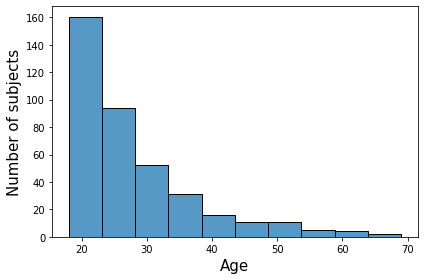

In [425]:
# Accuracy split by confidence
splot = sns.histplot(x="Age", bins = 10, stat = 'count', data=metaDage)
#plt.xlim([0,1])
plt.xlabel('Age',size=15)
plt.ylabel('Number of subjects',size=15)
plt.tight_layout()
plt.show;

In [427]:
D['Subject'].unique().size

387

In [98]:
plt.figure(1,(15,6))

## Plot accuracy bar overall
plt.subplot(1,2,1)
splot = sns.barplot(y="Subject", x="Correct", color="salmon", saturation=0.5,
            data=D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean())
#plt.ylim([0,1])
for p in splot.patches:
    splot.annotate(format(p.get_width(), '.3f'), 
                   (p.get_width(), p.get_y() + p.get_height() / 2.), 
                   ha = 'center', va = 'center', 
                   xytext = (20, 0), 
                   textcoords = 'offset points')
plt.xlabel('Accuracy',size=15)
plt.ylabel('Subject',size=15)
plt.xlim([-.05,1.05])
plt.tight_layout()

## Plot confidence bar overall
plt.subplot(1,2,2)
splot = sns.barplot(y="Subject", x="Confidence", color="salmon", saturation=0.5,
            data=D[['Subject','Confidence']].groupby(['Subject'],as_index=False).mean())
#plt.axvline(x=1, ls = '--')
#plt.ylim([0,1])
for p in splot.patches:
    splot.annotate(format(p.get_width(), '.3f'), 
                   (p.get_width(), p.get_y() + p.get_height() / 2.), 
                   ha = 'center', va = 'center', 
                   xytext = (20, 0), 
                   textcoords = 'offset points')
plt.xlabel('Proportion High Confidence',size=15)
plt.ylabel('Subject',size=15)
plt.xlim([-.05,1.05])
plt.tight_layout();

#plt.savefig('AccuracyConfidenceBar.png')

In [ ]:
q = D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()
q['ID'] = [i.split("_")[0] for i in q['Subject']]
q['Half'] = ["second" if "_" in i else 'first' for i in q['Subject']]
q = q.drop(columns = 'Subject').rename(columns = {'ID':'Subject'})
q = q.pivot(index = 'Subject', columns = 'Half',values = 'Correct').rename_axis(None, axis = "columns").reset_index()
q['diff'] = (q['second'] - q['first'])*100
q


In [ ]:
scipy.stats.ttest_rel(q['first'], q['second'])#, alternative = "less")

In [ ]:
splot = sns.barplot(y="Subject", x="diff", color="salmon", saturation=0.5,
            data=q)
#plt.ylim([0,1])
for p in splot.patches:
    splot.annotate(format(p.get_width(), '.1f'), 
                   (p.get_width(), p.get_y() + p.get_height() / 2.), 
                   ha = 'center', va = 'center', 
                   xytext = (20, 0), 
                   textcoords = 'offset points')
plt.xlabel('Difference in Accuracy (%)',size=15)
plt.ylabel('Subject',size=15)
#plt.xlim([-.05,1.05])
plt.tight_layout();

In [773]:
seq1 = D[D['Subject'] == "5dc368"]
seq2 = D[D['Subject'] == "5dc368_2"]

In [774]:
sum(seq1['Jar'] == seq1['Bead'])

413

In [775]:
sum(seq2['Jar'] == seq2['Bead'])

419

In [ ]:
plotnine.options.figure_size = (10, 6)
ggplot(D, aes("Trial", "Confidence")) + geom_point() + facet_wrap('Subject')

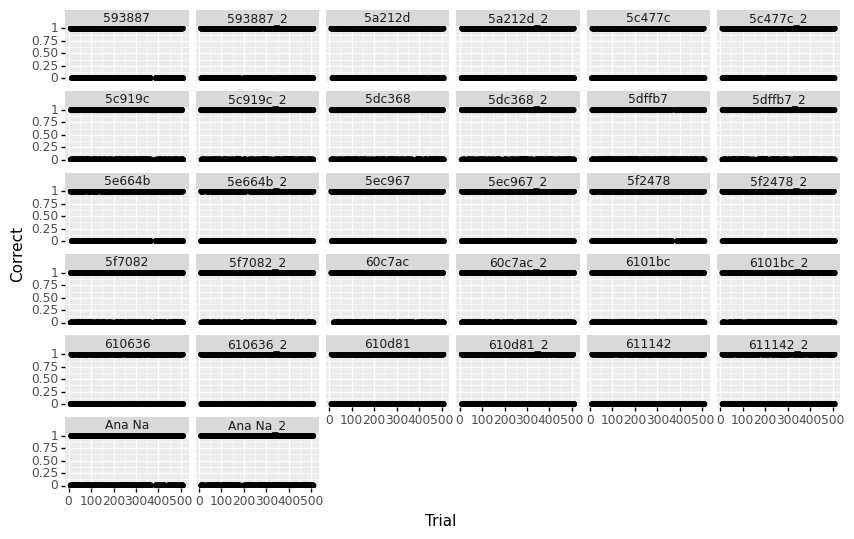

<ggplot: (8771187789817)>

In [777]:
ggplot(D, aes("Trial", "Correct")) + geom_point() + facet_wrap('Subject')

<Figure size 576x432 with 0 Axes>

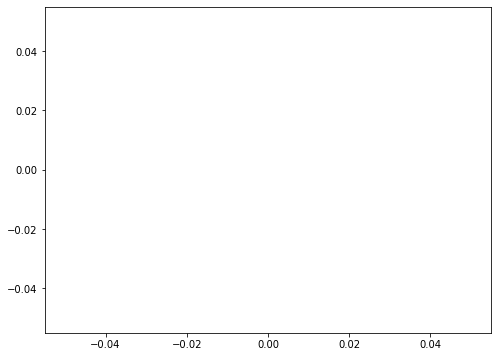

In [778]:
plt.figure(1,(8,6))
plt.plot("Trial", "Confidence",'.',data = D[D['Subject'] == '5e8b4c'])

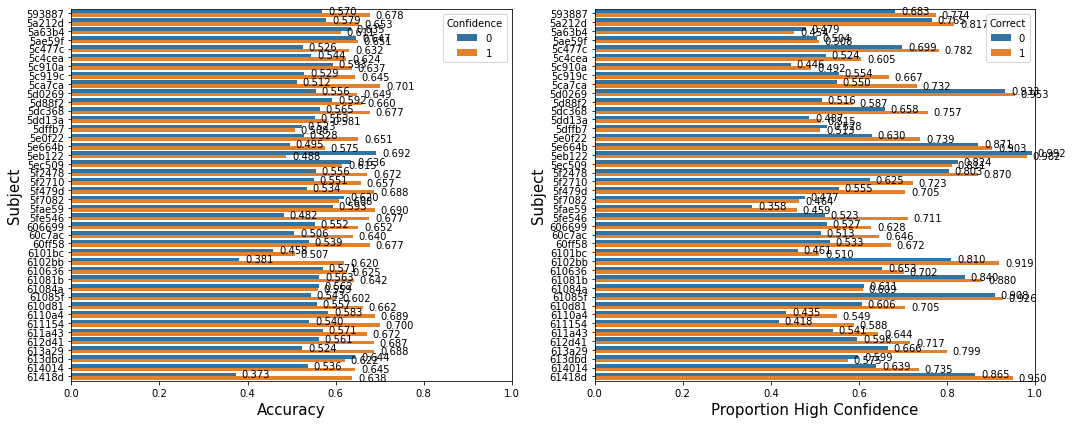

In [145]:
## Relationships between accuracy and confidence
plt.figure(1,(15,6))
# Accuracy split by confidence
plt.subplot(1,2,1)
splot = sns.barplot(y="Subject", x="Correct", hue="Confidence", 
            data=D[['Subject','Correct','Confidence']].groupby(['Subject','Confidence'],as_index=False).mean())
plt.xlim([0,1])
for p in splot.patches:
    splot.annotate(format(p.get_width(), '.3f'), 
                   (p.get_width(), p.get_y() + p.get_height() / 2.), 
                   ha = 'center', va = 'center', 
                   xytext = (20, 0), 
                   textcoords = 'offset points')
plt.xlabel('Accuracy',size=15)
plt.ylabel('Subject',size=15)
plt.tight_layout()

# Confidence split by correctness
plt.subplot(1,2,2)
splot = sns.barplot(y="Subject", x="Confidence", hue="Correct", 
            data=D[['Subject','Correct','Confidence']].groupby(['Subject','Correct'],as_index=False).mean())
plt.xlim([0,1])
for p in splot.patches:
    splot.annotate(format(p.get_width(), '.3f'), 
                   (p.get_width(), p.get_y() + p.get_height() / 2.), 
                   ha = 'center', va = 'center', 
                   xytext = (20, 0), 
                   textcoords = 'offset points')
plt.xlabel('Proportion High Confidence',size=15)
plt.ylabel('Subject',size=15)
plt.tight_layout();

#plt.savefig('AccuracyConfidenceSplitBar.png')

In [146]:
m = D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()['Correct'].mean()
v = D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()['Correct'].var()
s = D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()['Correct'].std()

m
v
s
m - 3*s

0.6101904761904761

0.001566694541231127

0.03958149240783029

0.49144599896698515

<Figure size 576x432 with 0 Axes>

Text(0, 0.5, 'Mutual Information between\n$X_{past}$ and $X_{future}$')

Text(0.5, 0, 'Window size of $X$ into the past')

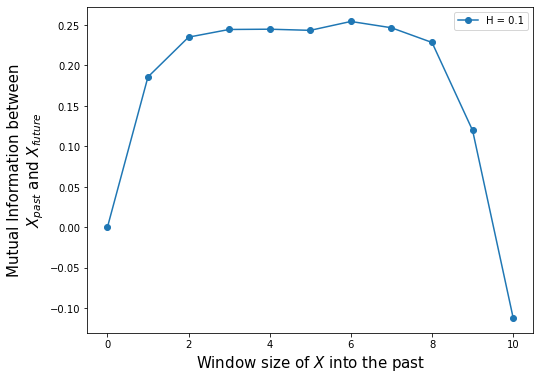

In [428]:
maxw = 10

bound_seq = D[D['FullSubject'] == D['FullSubject'].unique()[0]].copy()
bound_seq['History'] = sm.get_previous_n_beads(maxw, bound_seq['Bead'])

# Computed windowed predictive information in the low hazard rate
window_mi = sm.get_windowed_mi(bound_seq['History'],
                              bound_seq['Jar'],maxw)

# Plot predictive information as a function of window size
plt.figure(1,(8,6))
plt.plot(np.arange(maxw+1),window_mi,'-o',label='H = 0.1')
plt.ylabel('Mutual Information between\n$X_{past}$ and $X_{future}$',size=15)
plt.xlabel('Window size of $X$ into the past',size=15)
plt.legend()

<Figure size 576x432 with 0 Axes>

(0.0, 1.02)

Text(0.5, 0, '$I_{past}$')

Text(0, 0.5, '$I_{future}$')

Text(0.5, 1.0, 'Empirical Information Bottleneck Bound')

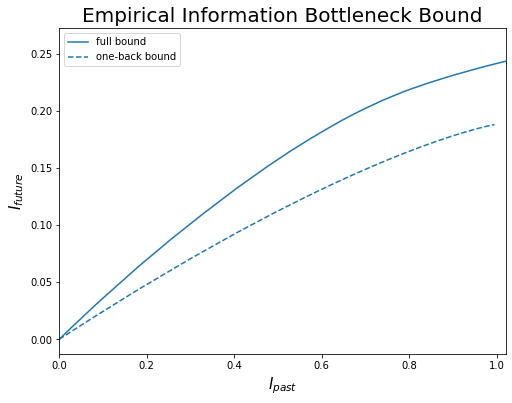

In [523]:
ip_fullbound,if_fullbound,ip_1backbound,if_1backbound = sm.get_windowed_bound(bound_seq['History'],
                                                             bound_seq['Jar'],6, maxbeta = 10)

    
# Plot bounds
plt.figure(1,(8,6))

# Low confidence rate
#plt.subplot(1,2,1)
plt.plot(ip_fullbound,if_fullbound,'-',color=cmap(0),label='full bound')
plt.plot(ip_1backbound,if_1backbound,'--',color=cmap(0), label='one-back bound')
plt.xlim([0,1.02])
plt.xlabel('$I_{past}$',size=15)
plt.ylabel('$I_{future}$',size=15)
plt.title('Empirical Information Bottleneck Bound',size=20)
plt.legend()

In [430]:
I_window = []

def window_helper(i_p, i_f, dname, includes):
    m = []
    for sub in i_p.keys():
        df = pd.DataFrame({
            'Subject':sub,
            'sim':dname,
            'includes':includes,
            'window':np.arange(len(i_p[sub])),
            'Ip':i_p[sub],
            'If':i_f[sub]
        })
        m.extend(df.values)
    return(m)

for dname,d in Ddict.items():
    ip_task, if_task = sm.get_windowed_mi_subs(d,6)
    ip_conf, if_conf = sm.get_windowed_mi_subs_confo(d,6)
    ip_both, if_both = sm.get_windowed_mi_subs_confid(d,6)
    
    I_window.extend(window_helper(ip_task, if_task, dname, "task"))
    I_window.extend(window_helper(ip_conf, if_conf, dname, "conf"))
    I_window.extend(window_helper(ip_both, if_both, dname, "both"))

I_window_df = pd.DataFrame(I_window, columns = ['Subject', 'sim', 'includes', 'window', 'Ip', "If"])
I_window_df

,Subject,sim,includes,window,Ip,If
0,60b610d8,orig,task,0,0.000000,0.186192
1,60b610d8,orig,task,1,0.977339,0.186192
2,60b610d8,orig,task,2,0.980274,0.186192
3,60b610d8,orig,task,3,0.982618,0.186192
4,60b610d8,orig,task,4,0.983374,0.186192
...,...,...,...,...,...,...
8626,610d8166,orig,both,2,0.809015,0.170902
8627,610d8166,orig,both,3,0.866476,0.170902
8628,610d8166,orig,both,4,0.872818,0.170902
8629,610d8166,orig,both,5,0.875214,0.170902


In [431]:
nboot = 10
Ip_boot = []
If_boot = []

def boot_helper(ip_boot, dname, includes):
    df = pd.DataFrame({
        'Subject':ip_boot.keys(),
        'sim':dname,
        'includes':includes,
        'mean':np.array([np.mean(ip_boot[key]) for key in ip_boot.keys()]),
        '95CI':np.array([np.std(ip_boot[key])*1.96 for key in ip_boot.keys()])
    })
    return(df)

for dname,d in Ddict.items():
    ip_task, if_task = sm.get_windowed_mi_subs(d,6)
    ip_conf, if_conf = sm.get_windowed_mi_subs_confo(d,6)
    ip_both, if_both = sm.get_windowed_mi_subs_confid(d,6)
    
    ip_task_boot, if_task_boot = sm.get_bootstrapped_samples(d,ip_task,nboot)
    ip_conf_boot, if_conf_boot = sm.get_bootstrapped_samples_confo(d,ip_conf,nboot)
    ip_both_boot, if_both_boot = sm.get_bootstrapped_samples_confid(d,ip_both,nboot)
    
    Ip_boot.extend(boot_helper(ip_task_boot, dname, "task").values)
    Ip_boot.extend(boot_helper(ip_conf_boot, dname, "conf").values)
    Ip_boot.extend(boot_helper(ip_both_boot, dname, "both").values)
    If_boot.extend(boot_helper(if_task_boot, dname, "task").values)
    If_boot.extend(boot_helper(if_conf_boot, dname, "conf").values)
    If_boot.extend(boot_helper(if_both_boot, dname, "both").values)

Ip_boot_df = pd.DataFrame(Ip_boot, columns = ['Subject', 'sim', 'includes', 'mean', '95CI'])
If_boot_df = pd.DataFrame(If_boot, columns = ['Subject', 'sim', 'includes', 'mean', '95CI'])

In [432]:
Ip_boot_df.head()
If_boot_df.head()

boot_data_full = pd.merge(Ip_boot_df,If_boot_df, on = ['Subject','sim','includes'], suffixes = ['_ip', '_if'])

,Subject,sim,includes,mean,95CI
0,60b610d8,orig,task,0.983675,0.007650
1,5929e024,orig,task,0.428619,0.050483
2,613cb9a1,orig,task,0.677177,0.060106
3,60c13bce,orig,task,0.889758,0.027242
4,603e5aad,orig,task,0.629685,0.043819


,Subject,sim,includes,mean,95CI
0,60b610d8,orig,task,0.191517,0.040549
1,5929e024,orig,task,0.077661,0.030886
2,613cb9a1,orig,task,0.128533,0.023306
3,60c13bce,orig,task,0.176668,0.033565
4,603e5aad,orig,task,0.126547,0.030569


In [448]:
#[colortemplate['colorhex'][i%len(colortemplate['colorhex'])] for i in np.arange(len(Ip_boot_df['Subject'].unique()))]

In [449]:
#colors = dict(zip(set(Ip_boot_df['Subject'].unique()), [cmap(i) for i in np.arange(len(Ip_boot_df['Subject'].unique()))]))
colors = dict(zip(set(Ip_boot_df['Subject'].unique()), [colortemplate['colorhex'][i%len(colortemplate['colorhex'])] for i in np.arange(len(Ip_boot_df['Subject'].unique()))]))
#colors = dict(zip(set(Ip_boot_df['includes'].unique()), [cmap(i) for i in np.arange(len(Ip_boot_df['includes'].unique()))]))

boot_data_full['color'] = boot_data_full['Subject'].map(colors)
#boot_data_full['label'] = boot_data_full['Subject'] + "_" + boot_data_full['sim'] + "_" + boot_data_full['includes']
boot_data_full['label'] = boot_data_full['Subject']

In [450]:
keys = set(i.split("_")[0] for i in Ip_boot_df['Subject'])
#keys
colors = dict(zip(keys, [colortemplate['colorhex'][i%len(colortemplate['colorhex'])] for i in np.arange(len(keys))]))
colors = dict(zip(keys, [colortemplate['colorhex'][2] for i in np.arange(len(keys))]))

boot_data_full['colorkey'] = [i.split("_")[0] for i in boot_data_full['Subject']]
boot_data_full['color'] = boot_data_full['colorkey'].map(colors)
#boot_data_full['label'] = boot_data_full['Subject'] + "_" + boot_data_full['sim'] + "_" + boot_data_full['includes']
boot_data_full['label'] = boot_data_full['Subject']

In [451]:
confacc = D[['Subject','Correct','Confidence']].groupby(['Subject','Confidence'],as_index=False).mean()\
.pivot(index='Subject',columns='Confidence',values='Correct')\
.rename(columns={0: "low", 1: "high"}).reset_index()

confacc['color'] = confacc['Subject'].map(colors)
confacc = confacc[(confacc['Subject'].isin(metaDw.Subject))]

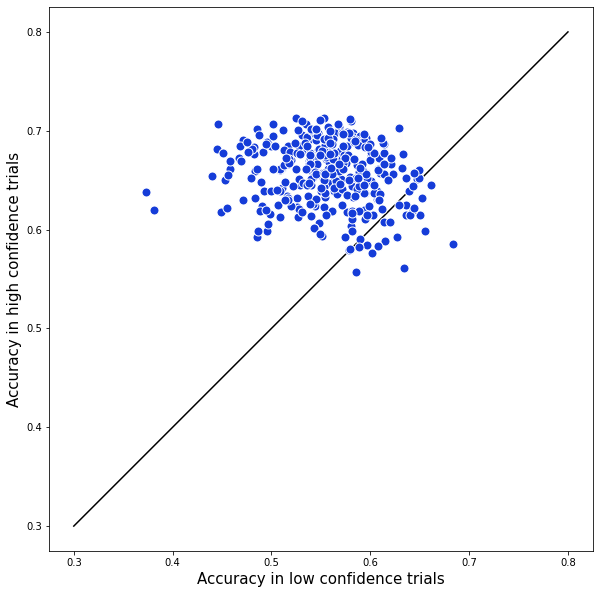

In [452]:
plt.figure(1,(10,10))
plt.subplot(111)
plt.plot([0.3,0.8],[0.3,0.8],'-k')
for index,row in confacc.iterrows():
    plt.plot(row['low'],row['high'],label = row['Subject'], marker = "o", markersize=9, mec='white', color = row['color'])
plt.axis('square')
plt.xlabel('Accuracy in low confidence trials',size=15)
plt.ylabel('Accuracy in high confidence trials',size=15)
plt.show;

In [454]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [526]:
acc.Correct.mean()
acc.Correct.std()

0.6135607235142119

0.03672433801423764

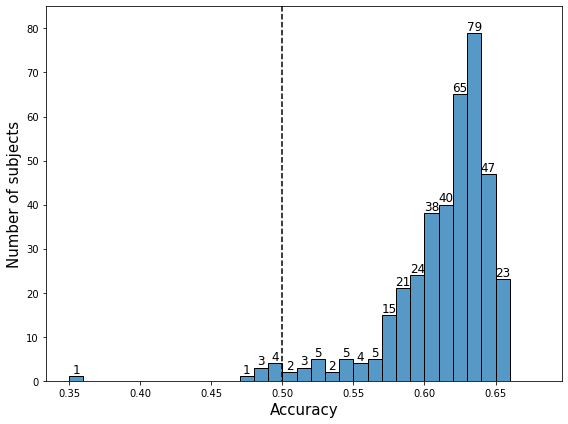

In [519]:
plt.figure(1,(8,6))
plt.plot([0.5,0.5],[85,0],'--k')
splot = sns.histplot(x="Correct", stat = 'count', binrange = (0.35, 0.67), binwidth = 0.01, data=acc)
for p in splot.patches: 
    splot.text(p.get_x() + p.get_width()/2.,
            p.get_height(),
            '{}'.format('' if p.get_height() == 0 else int(p.get_height())), 
            fontsize=12,
            ha='center',
            va='bottom')
plt.xlabel('Accuracy',size=15)
plt.ylabel('Number of subjects',size=15)
plt.ylim([0,85])
plt.tight_layout()
plt.show;

In [527]:
conf.Confidence.mean()
conf.Confidence.std()

0.6587777777777778

0.14141801199384912

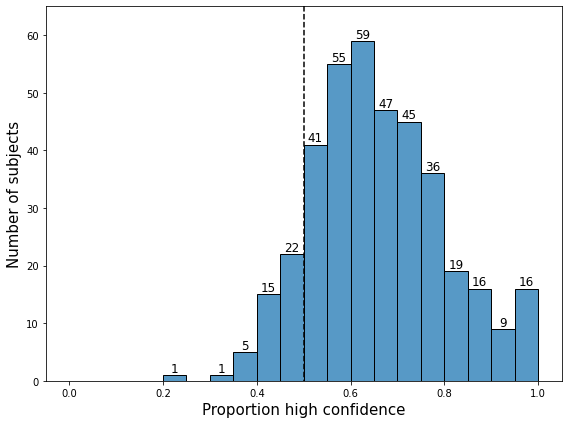

In [521]:
plt.figure(1,(8,6))
plt.plot([0.5,0.5],[65,0],'--k')
splot = sns.histplot(x="Confidence", stat = 'count', binrange = (0, 1), binwidth = 0.05, data=conf)
for p in splot.patches: 
    splot.text(p.get_x() + p.get_width()/2.,
            p.get_height(),
            '{}'.format('' if p.get_height() == 0 else int(p.get_height())), 
            fontsize=12,
            ha='center',
            va='bottom')
plt.xlabel('Proportion high confidence',size=15)
plt.ylabel('Number of subjects',size=15)
plt.ylim([0,65])
plt.tight_layout()
plt.show;

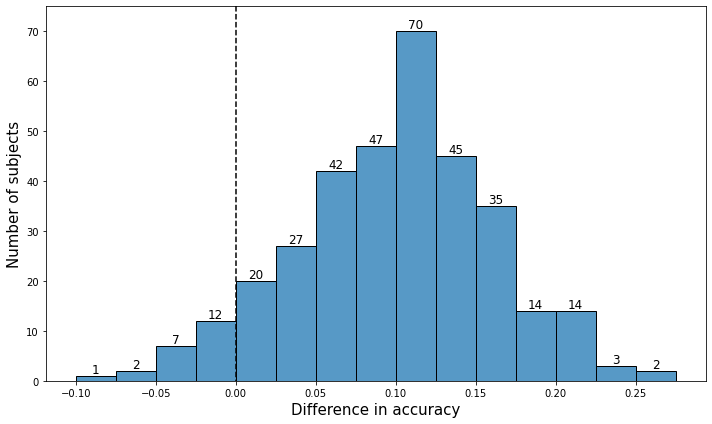

In [455]:
confacc = confacc.assign(diff = lambda d: d.high - d.low)

plt.figure(1,(10,6))
plt.plot([0,0],[75,0],'--k')
splot = sns.histplot(x="diff", stat = 'count', binrange = (-0.1, 0.3-0.025), binwidth = 0.025, data=confacc)
for p in splot.patches: 
    splot.text(p.get_x() + p.get_width()/2.,
            p.get_height(),
            '{}'.format(int(p.get_height())), 
            fontsize=12,
            ha='center',
            va='bottom')
plt.xlabel('Difference in accuracy',size=15)
plt.ylabel('Number of subjects',size=15)
plt.ylim([0,75])
plt.tight_layout()
plt.show;

In [534]:
confacc['diff'].mean()
confacc['diff'].std()

0.09887982147887979

0.06118993840626463

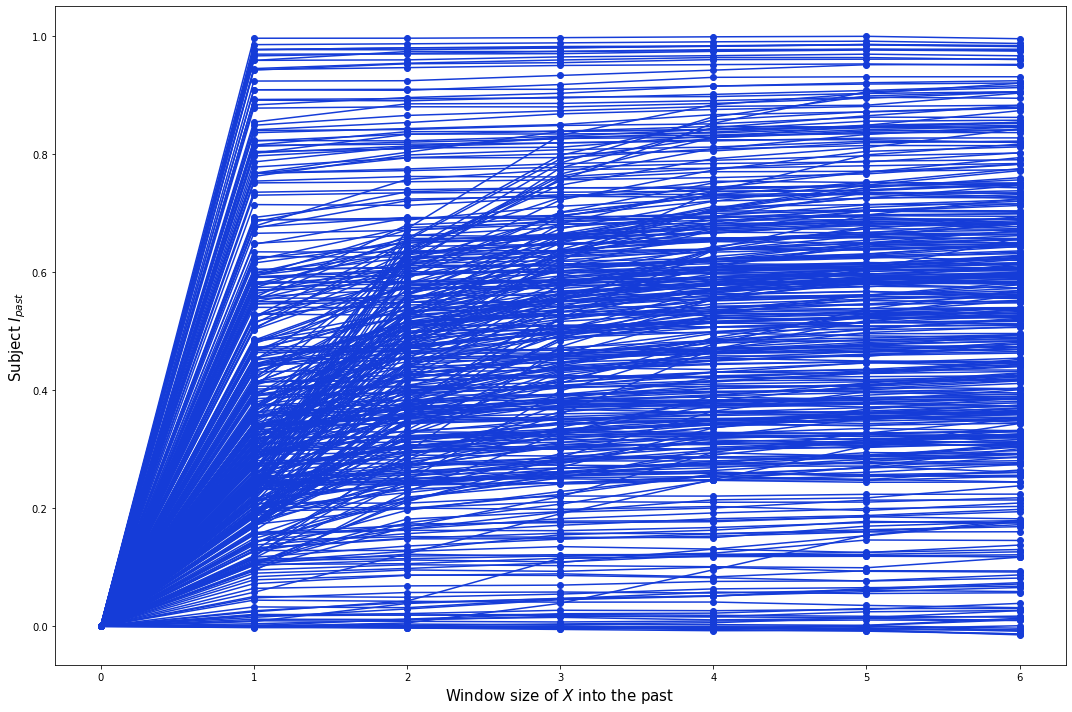

In [456]:
plt.figure(1,(15,10))
Itype = I_window_df[(I_window_df['sim'] == 'orig') & (I_window_df['includes'] == 'task')]
for sub in Itype['Subject'].unique():
    Isub = Itype[Itype['Subject'] == sub]
    plt.plot(Isub['window'],Isub['Ip'],'-o',label = sub,color=colors[sub.split("_")[0]])
#plt.legend(loc = 'upper left')        
plt.xlabel('Window size of $X$ into the past',size=15)
plt.ylabel('Subject $I_{past}$',size=15)
#plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show();

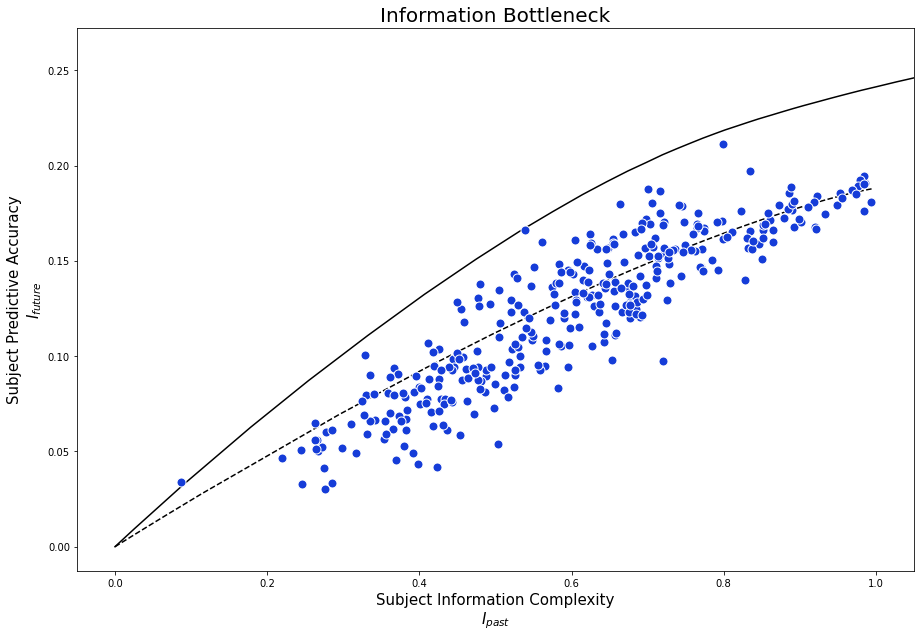

In [459]:
boot_data = boot_data_full[(boot_data_full['includes'] == "task") & (boot_data_full['Subject'].isin(metaDw.Subject))]

fig = plt.figure(1,(15,10))
ax = fig.add_subplot(111)
r,p=spearmanr(Ip_boot_df['mean'],If_boot_df['mean'])
ax.plot(ip_fullbound,if_fullbound,'-k')
ax.plot(ip_1backbound,if_1backbound,'--k')
#texts = []
for index,row in boot_data.iterrows():
    ax.errorbar(row['mean_ip'],row['mean_if'],#xerr=row['95CI_ip'],yerr = row['95CI_if'],
             marker='o',markersize=9,mec='white',color=row['color'],ls='none', label = row['label'])
    #texts.append(ax.text(row['mean_ip'],row['mean_if'],row['label'])) 
#adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
#ax.legend()
handles, labels = ax.get_legend_handles_labels()  
#lgd = dict(zip(labels, handles))
#ax.legend(lgd.values(), lgd.keys(), loc = "lower right")
plt.ylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('Information Bottleneck',size=20)
plt.xlim([-0.05, 1.05])
plt.show;

In [569]:
melted_boot = boot_data_full[['Subject', 'sim', 'includes', 'mean_ip', 'mean_if']]\
.melt(id_vars = ['Subject', 'sim', 'includes'])\
.assign(variable = lambda g: [i.split("_")[1] for i in g.variable])\
.rename(columns={"value": "mean"})

Ifuture_both = melted_boot[(melted_boot['sim'] == "orig") & (melted_boot['includes'] == "both") & (melted_boot['variable'] == "if")]\
.rename(columns={"mean":"Ifuture_both"})\
.drop(columns=['variable', 'includes'])
Ifuture_task = melted_boot[(melted_boot['sim'] == "orig") & (melted_boot['includes'] == "task") & (melted_boot['variable'] == "if")]\
.rename(columns={"mean":"Ifuture_task"})\
.drop(columns=['variable', 'includes'])
Ipast_task = melted_boot[(melted_boot['sim'] == "orig") & (melted_boot['includes'] == "task") & (melted_boot['variable'] == "ip")]\
.rename(columns={"mean":"Ipast_task"})\
.drop(columns=['variable', 'includes'])
Ipast_both = melted_boot[(melted_boot['sim'] == "orig") & (melted_boot['includes'] == "both") & (melted_boot['variable'] == "ip")]\
.rename(columns={"mean":"Ipast_both"})\
.drop(columns=['variable', 'includes'])

In [598]:
IBTforgrant = Ifuture_both.merge(Ifuture_task)\
.merge(Ipast_task)\
.merge(Ipast_both)\
.assign(ratio = lambda d: d.Ifuture_both/d.Ifuture_task)\
.assign(diff = lambda d: d.Ifuture_both - d.Ifuture_task)\
.assign(pastdiff = lambda d: d.Ipast_both - d.Ipast_task)#\
#.assign(logdiff = lambda d: math.log(d.Ifuture_both) - math.log(d.Ifuture_task))

#IBTforgrant

In [599]:
IBtable = Ifuture_both.merge(Ifuture_task)\
.merge(Ipast_task)\
.assign(ratio = lambda d: d.Ifuture_both/d.Ifuture_task)\
.assign(diff = lambda d: d.Ifuture_both - d.Ifuture_task)#\
#.assign(logdiff = lambda d: math.log(d.Ifuture_both) - math.log(d.Ifuture_task))

IBtable = IBTforgrant

In [583]:
metaDw[metaDw['Subject'] == '613a7ca0']

,FullSubject,Subject,Gender,Age,Ethnicity,Correct,Confidence
204,613a7ca0c1800b1751d64ef1,613a7ca0,Female,24,White,0.585,0.59


In [584]:
IBtable[IBtable['Subject'] == "613a87"]
dup = print([s for s in acc['Subject'] if "613a87" in s])
dup = print([s for s in acc['Subject'] if "613a7c" in s])
dup = print([s for s in acc['Subject'] if "613ae7" in s])
sub = '613ae7ee'

acc[acc['Subject'] == sub]
conf[conf['Subject'] == sub]

,Subject,sim,Ifuture_both,Ifuture_task,Ipast_task,Ipast_both,ratio,diff,pastdiff


['613a8742', '613a87bd']
['613a7c75', '613a7ca0']
['613ae704', '613ae7ee']


,Subject,Correct
314,613ae7ee,0.524


,Subject,Confidence
314,613ae7ee,0.661


In [575]:
metaDw

,FullSubject,Subject,Gender,Age,Ethnicity,Correct,Confidence
0,60b610d8c3c4f177c8337729,60b610d8,Male,36,White,0.654,0.655
1,5929e024943e670001cde06b,5929e024,Female,28,White,0.593,0.510
2,613cb9a1ccf4ca3a5150522e,613cb9a1,Male,23,White,0.626,0.516
3,60c13bce0d8616e48d044bd0,60c13bce,Male,26,White,0.653,0.645
4,603e5aad160c3ee04e07e8d3,603e5aad,Male,26,White,0.625,0.611
...,...,...,...,...,...,...,...
336,5e27350b928d3e94def42ff7,5e27350b,Male,21,White,0.623,0.831
337,60d20236448971833317b4a9,60d20236,Male,20,White,0.627,0.479
338,611154fe069a615f244b49aa,611154fe,Female,24,White,0.624,0.524
339,5ee00b0d5f5ead34f63f2c47,5ee00b0d,Male,26,White,0.644,0.805


In [600]:
IBtable = IBtable[IBtable['Subject'].isin(metaDw.Subject)].reset_index(drop = True)
IBtable

,Subject,sim,Ifuture_both,Ifuture_task,Ipast_task,Ipast_both,ratio,diff,pastdiff
0,60b610d8,orig,0.236666,0.191517,0.983675,1.892701,1.235745,0.045149,0.909027
1,5929e024,orig,0.129099,0.077661,0.428619,0.773450,1.662348,0.051438,0.344832
2,613cb9a1,orig,0.187829,0.128533,0.677177,1.131680,1.461322,0.059295,0.454504
3,60c13bce,orig,0.233820,0.176668,0.889758,1.677638,1.323503,0.057152,0.787880
4,603e5aad,orig,0.157193,0.126547,0.629685,0.921451,1.242163,0.030645,0.291766
...,...,...,...,...,...,...,...,...,...
336,5e27350b,orig,0.138198,0.128577,0.605603,0.818560,1.074827,0.009621,0.212957
337,60d20236,orig,0.184994,0.162487,0.804532,1.034220,1.138519,0.022508,0.229688
338,611154fe,orig,0.187034,0.155937,0.757589,1.223948,1.199417,0.031097,0.466359
339,5ee00b0d,orig,0.185058,0.154754,0.746078,1.246925,1.195816,0.030303,0.500847


In [577]:
ip_fullbound

array([9.56399541e-15, 2.92006976e-09, 6.12964895e-07, 1.02420003e-06,
       1.76876223e-05, 3.19227061e-05, 7.85527312e-05, 5.70834325e-04,
       1.65409609e-03, 5.92344044e-03, 2.53318597e-02, 8.99554692e-02,
       1.79653546e-01, 2.56178018e-01, 3.30399748e-01, 4.07268100e-01,
       4.74472753e-01, 5.30773206e-01, 5.75452000e-01, 6.13328516e-01,
       6.46430637e-01, 6.73872561e-01, 6.97990393e-01, 7.19509122e-01,
       7.38340624e-01, 7.56407319e-01, 7.72800214e-01, 7.87374584e-01,
       8.01612263e-01, 8.18150995e-01, 8.32192176e-01, 8.45619078e-01,
       8.63838655e-01, 8.76946387e-01, 8.89783470e-01, 9.06610238e-01,
       9.24149932e-01, 9.38398372e-01, 9.53576160e-01, 9.65902325e-01,
       9.79831232e-01, 9.98937352e-01, 1.01210334e+00, 1.02563749e+00,
       1.04009361e+00, 1.05351886e+00, 1.06665433e+00, 1.07845886e+00,
       1.09074741e+00, 1.10432536e+00, 1.11617905e+00, 1.12715847e+00,
       1.13968739e+00, 1.15074309e+00, 1.16240495e+00, 1.17328404e+00,
      

In [601]:
# Compute distance from the bound for each subject
IBtable['DTB'] = np.zeros(len(IBtable['Subject'].unique()))
for i,entry in IBtable.iterrows():
    IBtable['DTB'][i] = sm.DTB(D[D['Subject'] == entry['Subject']].reset_index(drop = True),entry['Ipast_task'],entry['Ifuture_task'],
                           ip_fullbound, if_fullbound)


/Users/vwang/anaconda3/envs/ndd/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [602]:
cc = dict(zip(boot_data_full.Subject,boot_data_full.color))
#cc
IBtable['color'] = IBtable.Subject.map(cc)

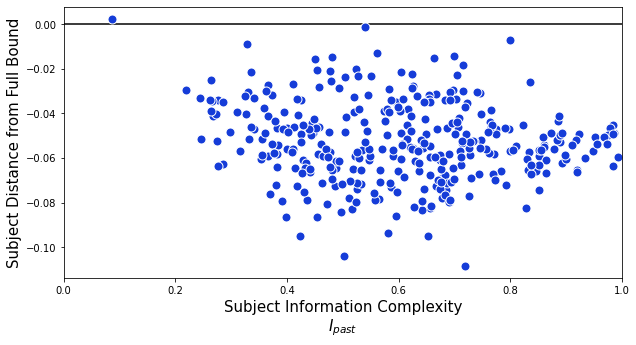

In [469]:
    # Plot distance from the bound for each hazard rate
plt.figure(1,(10,5))
# Low hazard
plt.subplot(111)
r,p=spearmanr(IBtable['Ipast_task'],IBtable['DTB'])
plt.plot([0,1],[0,0],'-k',label='full bound')
texts = []
for index,row in IBtable.iterrows():
        plt.plot(row['Ipast_task'],row['DTB'],label = row['Subject'], marker = "o", markersize=9, mec='white', color=row['color'])
        #texts.append(plt.text(row['Ipast_task'],row['DTB'],row['Subject'])) 
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
plt.ylabel('Subject Distance from Full Bound',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.xlim([0,1]);
#plt.ylim([-.5,.12])

In [470]:
IBtable.sort_values(by = ['Ifuture_task'])#,ascending=False)

,Subject,sim,Ifuture_both,Ifuture_task,Ipast_task,ratio,diff,DTB,color
160,5d5daa04,orig,0.037302,0.030475,0.276579,1.224018,0.006827,-0.063464,#153cd8
253,614721cb,orig,0.048931,0.032963,0.246355,1.484422,0.015968,-0.051647,#153cd8
87,6154474d,orig,0.035885,0.033647,0.284679,1.066492,0.002237,-0.062752,#153cd8
137,604c285c,orig,0.038707,0.033744,0.086788,1.147052,0.004962,0.002278,#153cd8
23,5fa45dc9,orig,0.058320,0.041131,0.274953,1.417892,0.017188,-0.052313,#153cd8
...,...,...,...,...,...,...,...,...,...
0,60b610d8,orig,0.236666,0.191517,0.983675,1.235745,0.045149,-0.048259,#153cd8
117,5f0c6887,orig,0.227587,0.192500,0.978775,1.182268,0.035087,-0.046796,#153cd8
47,614f2977,orig,0.190051,0.194402,0.983799,0.977620,-0.004351,-0.045386,#153cd8
218,613041ad,orig,0.225637,0.196982,0.835039,1.145469,0.028655,-0.026130,#153cd8


In [603]:
#IBtable\
#.drop(columns = ['sim', 'Ifuture_both', 'Ifuture_task'])\
#.to_csv("../UrnConfidenceQuestionnaire/Data/IBtable1010.csv", index=False)

IBtable\
.drop(columns = ['sim'])\
#.to_csv("../UrnConfidenceQuestionnaire/Data/IBtable1021forgrant.csv", index=False)

In [604]:
IBtable

,Subject,sim,Ifuture_both,Ifuture_task,Ipast_task,Ipast_both,ratio,diff,pastdiff,DTB,color
0,60b610d8,orig,0.236666,0.191517,0.983675,1.892701,1.235745,0.045149,0.909027,-0.048248,#153cd8
1,5929e024,orig,0.129099,0.077661,0.428619,0.773450,1.662348,0.051438,0.344832,-0.060737,#153cd8
2,613cb9a1,orig,0.187829,0.128533,0.677177,1.131680,1.461322,0.059295,0.454504,-0.069231,#153cd8
3,60c13bce,orig,0.233820,0.176668,0.889758,1.677638,1.323503,0.057152,0.787880,-0.053080,#153cd8
4,603e5aad,orig,0.157193,0.126547,0.629685,0.921451,1.242163,0.030645,0.291766,-0.061426,#153cd8
...,...,...,...,...,...,...,...,...,...,...,...
336,5e27350b,orig,0.138198,0.128577,0.605603,0.818560,1.074827,0.009621,0.212957,-0.054089,#153cd8
337,60d20236,orig,0.184994,0.162487,0.804532,1.034220,1.138519,0.022508,0.229688,-0.056597,#153cd8
338,611154fe,orig,0.187034,0.155937,0.757589,1.223948,1.199417,0.031097,0.466359,-0.056068,#153cd8
339,5ee00b0d,orig,0.185058,0.154754,0.746078,1.246925,1.195816,0.030303,0.500847,-0.055418,#153cd8


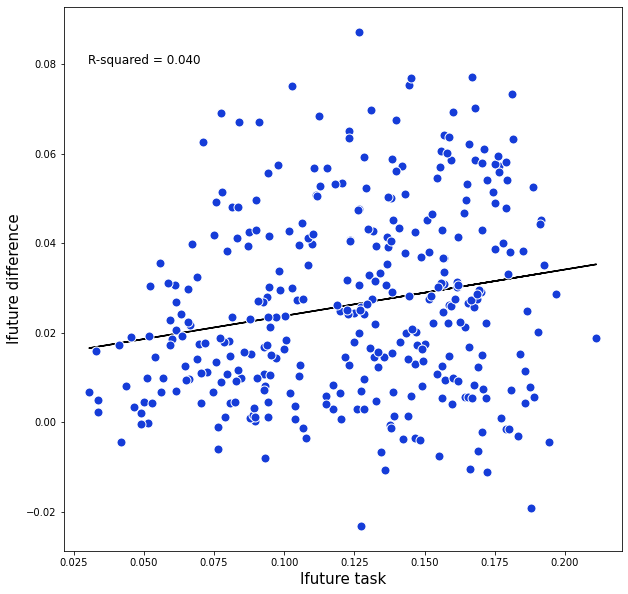

In [552]:
plt.figure(1,(10,10))
# Low hazard
plt.subplot(111)
res = scipy.stats.linregress(IBtable['Ifuture_task'], IBtable['diff'])
plt.plot(IBtable['Ifuture_task'], res.slope*IBtable['Ifuture_task'] + res.intercept, '-k')
#plt.annotate("R-squared = {:.3f}\np-value = {:.3e}".format(res.rvalue**2, res.pvalue), (0.03, 0.08), size = 12)
plt.annotate("R-squared = {:.3f}".format(res.rvalue**2), (0.03, 0.08), size = 12)
for index,row in IBtable.iterrows():
        plt.plot(row['Ifuture_task'],row['diff'],label = row['Subject'], marker = "o", markersize=9, mec='white', color=row['color'])
plt.xlabel('Ifuture task',size=15)
plt.ylabel('Ifuture difference',size=15)
#plt.xlim([-0.02,0.27])
#plt.ylim([-5,5])
plt.show;

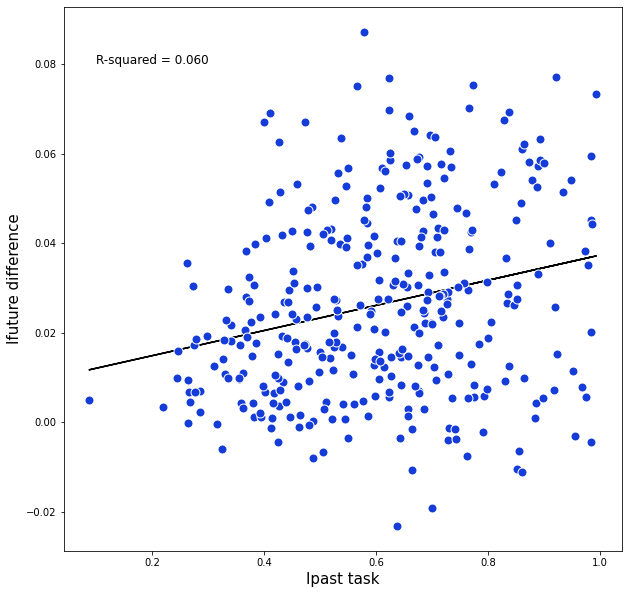

In [554]:
plt.figure(1,(10,10))
# Low hazard
plt.subplot(111)
res = scipy.stats.linregress(IBtable['Ipast_task'], IBtable['diff'])
plt.plot(IBtable['Ipast_task'], res.slope*IBtable['Ipast_task'] + res.intercept, '-k')
#plt.annotate("R-squared = {:.3f}\np-value = {:.3e}".format(res.rvalue**2, res.pvalue), (0.1, 0.08), size = 12)
plt.annotate("R-squared = {:.3f}".format(res.rvalue**2), (0.1, 0.08), size = 12)
for index,row in IBtable.iterrows():
        plt.plot(row['Ipast_task'],row['diff'],label = row['Subject'], marker = "o", markersize=9, mec='white', color=row['color'])
plt.xlabel('Ipast task',size=15)
plt.ylabel('Ifuture difference',size=15)
#plt.xlim([-0.02,0.27])
#plt.ylim([-5,5])
plt.show;

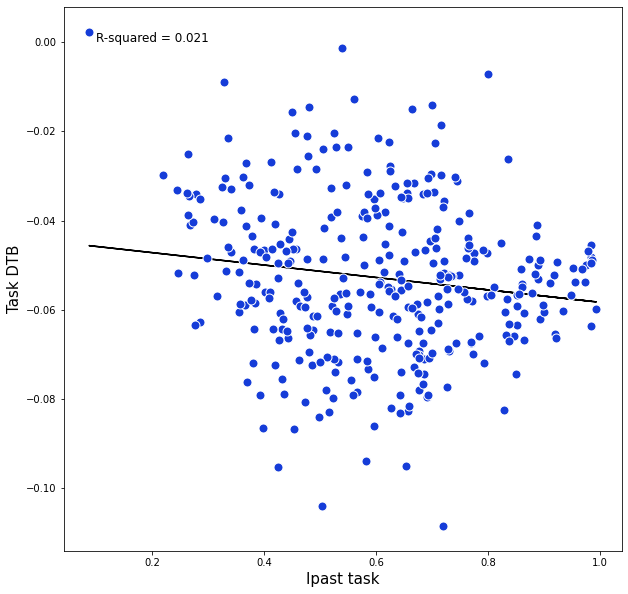

In [558]:
plt.figure(1,(10,10))
# Low hazard
plt.subplot(111)
res = scipy.stats.linregress(IBtable['Ipast_task'], IBtable['DTB'])
plt.plot(IBtable['Ipast_task'], res.slope*IBtable['Ipast_task'] + res.intercept, '-k')
#plt.annotate("R-squared = {:.3f}\np-value = {:.3e}".format(res.rvalue**2, res.pvalue), (0.1, 0.08), size = 12)
plt.annotate("R-squared = {:.3f}".format(res.rvalue**2), (0.1, 0), size = 12)
for index,row in IBtable.iterrows():
        plt.plot(row['Ipast_task'],row['DTB'],label = row['Subject'], marker = "o", markersize=9, mec='white', color=row['color'])
plt.xlabel('Ipast task',size=15)
plt.ylabel('Task DTB',size=15)
#plt.xlim([-0.02,0.27])
#plt.ylim([-5,5])
plt.show;

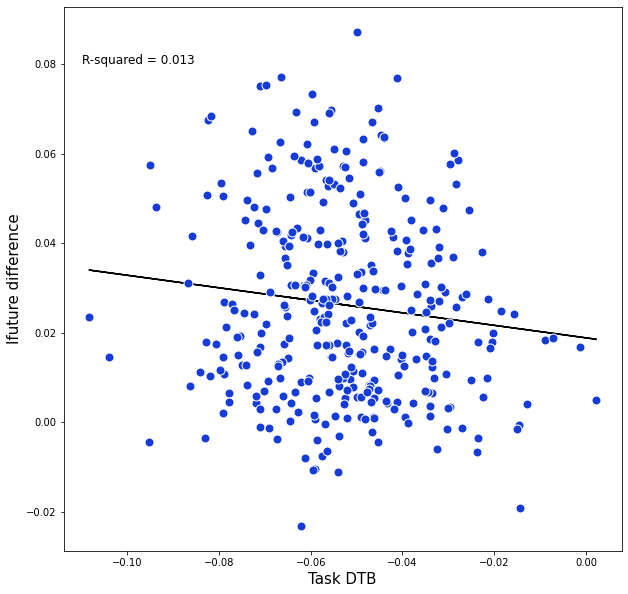

In [592]:
plt.figure(1,(10,10))
# Low hazard
plt.subplot(111)
res = scipy.stats.linregress(IBtable['DTB'], IBtable['diff'])
plt.plot(IBtable['DTB'], res.slope*IBtable['DTB'] + res.intercept, '-k')
#plt.annotate("R-squared = {:.3f}\np-value = {:.3e}".format(res.rvalue**2, res.pvalue), (0.1, 0.08), size = 12)
plt.annotate("R-squared = {:.3f}".format(res.rvalue**2), (-0.11, 0.08), size = 12)
for index,row in IBtable.iterrows():
        plt.plot(row['DTB'],row['diff'],label = row['Subject'], marker = "o", markersize=9, mec='white', color=row['color'])
plt.xlabel('Task DTB',size=15)
plt.ylabel('Ifuture difference',size=15)
#plt.xlim([-0.02,0.27])
#plt.ylim([-5,5])
plt.show;

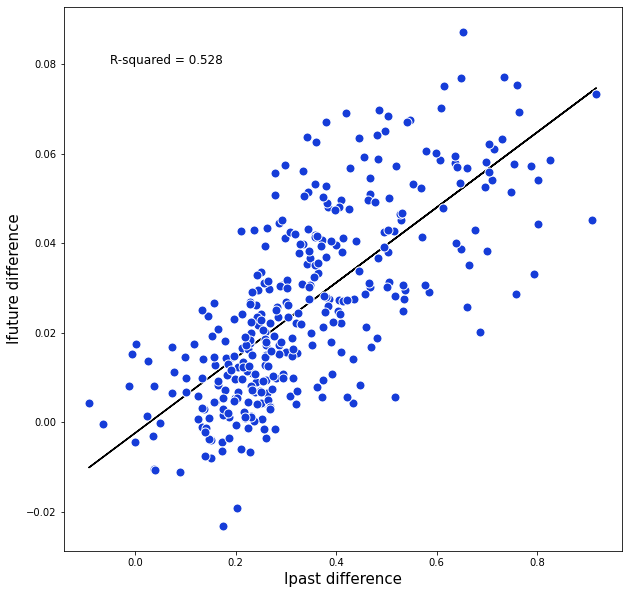

In [596]:
plt.figure(1,(10,10))
# Low hazard
plt.subplot(111)
res = scipy.stats.linregress(IBtable['pastdiff'], IBtable['diff'])
plt.plot(IBtable['pastdiff'], res.slope*IBtable['pastdiff'] + res.intercept, '-k')
#plt.annotate("R-squared = {:.3f}\np-value = {:.3e}".format(res.rvalue**2, res.pvalue), (0.1, 0.08), size = 12)
plt.annotate("R-squared = {:.3f}".format(res.rvalue**2), (-0.05, 0.08), size = 12)
for index,row in IBtable.iterrows():
        plt.plot(row['pastdiff'],row['diff'],label = row['Subject'], marker = "o", markersize=9, mec='white', color=row['color'])
plt.xlabel('Ipast difference',size=15)
plt.ylabel('Ifuture difference',size=15)
#plt.xlim([-0.02,0.27])
#plt.ylim([-5,5])
plt.show;

In [35]:
s = 0
exprun = 0
for i in range(100):
    s = s + 0.9**i * 0.1
    exprun = exprun + (i+1) * 0.9**i * 0.1
    print(i + 1, s)
    
exprun

1 0.1
2 0.19
3 0.271
4 0.34390000000000004
5 0.40951000000000004
6 0.46855900000000006
7 0.5217031000000001
8 0.5695327900000001
9 0.6125795110000001
10 0.6513215599000001
11 0.68618940391
12 0.7175704635190001
13 0.7458134171671001
14 0.7712320754503902
15 0.7941088679053512
16 0.8146979811148161
17 0.8332281830033345
18 0.849905364703001
19 0.8649148282327009
20 0.8784233454094309
21 0.8905810108684878
22 0.9015229097816391
23 0.9113706188034751
24 0.9202335569231277
25 0.928210201230815
26 0.9353891811077335
27 0.9418502629969602
28 0.9476652366972642
29 0.9528987130275378
30 0.9576088417247841
31 0.9618479575523058
32 0.9656631617970752
33 0.9690968456173678
34 0.972187161055631
35 0.974968444950068
36 0.9774716004550612
37 0.9797244404095551
38 0.9817519963685997
39 0.9835767967317397
40 0.9852191170585658
41 0.9866972053527092
42 0.9880274848174383
43 0.9892247363356945
44 0.9903022627021251
45 0.9912720364319126
46 0.9921448327887215
47 0.9929303495098494
48 0.9936373145588645
4

9.997078246122369

In [38]:
bound_seq

,FullSubject,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
0,5c102d91e32f860001651a93,5c102d,10,0,0,1,0,0,00000000000
1,5c102d91e32f860001651a93,5c102d,11,0,0,0,0,1,00000000000
2,5c102d91e32f860001651a93,5c102d,12,0,0,0,1,1,00000000000
3,5c102d91e32f860001651a93,5c102d,13,0,0,0,1,1,00000000000
4,5c102d91e32f860001651a93,5c102d,14,0,0,0,1,1,00000000000
...,...,...,...,...,...,...,...,...,...
995,5c102d91e32f860001651a93,5c102d,1005,0,0,0,1,1,00010100000
996,5c102d91e32f860001651a93,5c102d,1006,0,1,0,1,0,00101000000
997,5c102d91e32f860001651a93,5c102d,1007,0,0,0,0,1,01010000001
998,5c102d91e32f860001651a93,5c102d,1008,0,1,0,1,0,00100000010


In [39]:
j = bound_seq['Jar']
b = bound_seq['Bead']

In [67]:
c = 1
prev = 1
maxc = 0
runlengths = []
for i in b:
    if prev == i:
        c = c + 1
    else: 
        runlengths.append(c)
        c = 1
    maxc = max(maxc,c)
    prev = i
c
runlengths

1

[1,
 5,
 5,
 1,
 1,
 4,
 5,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 4,
 1,
 1,
 3,
 3,
 1,
 1,
 2,
 4,
 3,
 1,
 5,
 3,
 2,
 1,
 3,
 1,
 1,
 1,
 6,
 1,
 2,
 2,
 4,
 3,
 3,
 2,
 4,
 1,
 1,
 3,
 1,
 6,
 2,
 4,
 4,
 3,
 2,
 1,
 9,
 7,
 1,
 3,
 1,
 2,
 1,
 5,
 6,
 7,
 1,
 6,
 3,
 1,
 8,
 11,
 1,
 2,
 3,
 5,
 2,
 1,
 6,
 1,
 4,
 2,
 3,
 2,
 1,
 4,
 6,
 1,
 7,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 4,
 5,
 1,
 1,
 3,
 1,
 3,
 2,
 1,
 1,
 1,
 3,
 1,
 5,
 1,
 4,
 8,
 1,
 4,
 1,
 2,
 2,
 1,
 2,
 1,
 5,
 2,
 1,
 7,
 1,
 2,
 2,
 1,
 6,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 24,
 2,
 6,
 1,
 3,
 1,
 1,
 1,
 1,
 6,
 3,
 10,
 2,
 3,
 15,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 3,
 3,
 1,
 5,
 4,
 1,
 2,
 2,
 3,
 1,
 2,
 1,
 1,
 2,
 9,
 7,
 4,
 1,
 1,
 2,
 2,
 6,
 5,
 2,
 11,
 1,
 3,
 5,
 2,
 8,
 4,
 2,
 1,
 7,
 2,
 5,
 1,
 7,
 1,
 1,
 3,
 1,
 2,
 1,
 3,
 3,
 8,
 6,
 1,
 1,
 1,
 4,
 1,
 4,
 1,
 6,
 2,
 5,
 1,
 7,
 1,
 5,
 1,
 9,
 1,
 2,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 2,
 7,
 1,
 16,
 1,
 2,
 1,
 6,
 13,
 1,
 3,
 6,
 1,
 1,
 6,
 1,
 7,
 

In [68]:
statistics.mean(runlengths)

2.898550724637681

In [69]:
max(runlengths)

24